# Long Lab 3 – COVID-19 Tweet Analysis  
**Course:** Data Mining – Fall 2025  
**University:** University of Rochester  
**Student:** Mouhamed Mbengue  



## Part I: Setting Up the Data
### Q1: Import and Clean Tweets Dataset

- Import the original tweets dataset.  
- Drop duplicate entries based on `status_id`.  
- Randomly sample 500,000 tweets.  
- Import the U.S. states reference file.  
- Filter tweets that reference exactly one U.S. state.  
- Report the number of rows before and after cleaning, percentage of data lost, and elapsed time.


#### Import Dataset

In [1]:
# Imports
import pandas as pd
import numpy as np
import time, random, os, re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA
from pandas.plotting import parallel_coordinates
import nltk
from nltk.corpus import stopwords
# Download stopwords once
nltk.download("stopwords")
# Set fixed random seed for reproducibility 
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

print("Libraries imported successfully.")



Libraries imported successfully.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mouhamed23/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Load the full Dataset

In [2]:
# Load the full tweets dataset
start_time = time.time()
tweets_us_df = pd.read_csv("us_tweets_final.csv", dtype=str, encoding="utf-8", low_memory=False)
# print results for logs
print(f"Original dataset rows: {tweets_us_df.shape[0]}")
print(f"Columns: {tweets_us_df.shape[1]}")
print(f"Loaded in {time.time() - start_time:.2f} seconds")



Original dataset rows: 7901191
Columns: 26
Loaded in 177.98 seconds


#### Drop Duplicate Rows 

In [ ]:
dup_count = tweets_us_df["status_id"].duplicated().sum()
unique_count = tweets_us_df["status_id"].nunique()

print(f"Duplicate count (exact match): {dup_count}")
print(f"Unique count: {unique_count}")
print(f"Total rows: {len(tweets_us_df)}")

# check any white space
whitespace = tweets_us_df["status_id"].str.strip().duplicated().sum()
print(f"Duplicates after stripping whitespace: {whitespace}")


Duplicate count (exact match): 0
Unique count: 7901190
Total rows: 7901191
Duplicates after stripping whitespace: 0


In [3]:
before_dedup = len(tweets_us_df)
tweets_us_df = tweets_us_df.drop_duplicates(subset=["status_id"])
after_dedup = len(tweets_us_df)

print("Rows before deduplication:", before_dedup)
print("Rows after deduplication:", after_dedup)
print("Duplicates removed:", before_dedup - after_dedup)



Rows before deduplication: 7901191
Rows after deduplication: 7901191
Duplicates removed: 0


#### Sample 500,000 rows from the dataset

In [5]:
if len(tweets_us_df) >= 500000:
    tweets_us_df = tweets_us_df.sample(n=500000, random_state=42)
    print("Sampled 500,000 rows.")
else:
    print(f"Dataset has only {len(tweets_us_df)} rows after deduplication, keeping all.")

print("Shape after sampling:", tweets_us_df.shape)



Sampled 500,000 rows.
Shape after sampling: (500000, 26)


#### Read the states dataset

In [6]:
us_states_df = pd.read_excel("us_states.xlsx")
print("us_states_df shape:", us_states_df.shape)
print(us_states_df.head())


us_states_df shape: (50, 2)
        state region
0     Alabama  South
1      Alaska   West
2     Arizona   West
3    Arkansas  South
4  California   West


#### Normalize Single State Tweets

In [7]:
# Normalize and find valid single state tweets
# get locatioon
tweets_us_df["location"] = tweets_us_df["location"].astype(str).str.lower()
# get state
us_states_df["state"] = us_states_df["state"].astype(str).str.lower()

states_pattern = re.compile(r'\b(' + '|'.join(map(re.escape, us_states_df["state"])) + r')\b')

def find_states(text):
    if not isinstance(text, str) or not text.strip():
        return []
    return states_pattern.findall(text)

tweets_us_df["state_matches"] = tweets_us_df["location"].apply(find_states)

before_filter = len(tweets_us_df)
tweets_us_df = tweets_us_df[tweets_us_df["state_matches"].apply(lambda x: len(x) == 1)]
after_filter = len(tweets_us_df)
data_lost = ((before_filter - after_filter) / before_filter) * 100

print("Rows before filtering:", before_filter)
print("Rows after filtering:", after_filter)
print("Exact count of data lost:", before_filter - after_filter)
print(f"Data lost: {data_lost:.2f}%")


Rows before filtering: 500000
Rows after filtering: 497503
Exact count of data lost: 2497
Data lost: 0.50%


#### Elapsed Time 

In [8]:
elapsed_time_q1 = time.time() - start_time
print(f"Elapsed time for Q1: {elapsed_time_q1:.2f} seconds")

Elapsed time for Q1: 538.32 seconds


## Part II: Adding Date, State, and Region Information
### Q2: Extract and Merge Time and Regional Attributes

- Extract the **day** (YYYY-MM-DD) from the `created_at` field.  
- Derive the **state** for each tweet using the cleaned `state_matches` column.  
- Merge with the U.S. states reference table to attach the **region**.  
- Record the elapsed time for Q2 and confirm successful integration of all columns.

In [9]:
# Q2 – Add day, state, and region
import time
import numpy as np
import pandas as pd
start_time = time.time()
#Extract day (YYYY-MM-DD) 
tweets_us_df["day"] = pd.to_datetime(
    tweets_us_df["created_at"], errors="coerce"
).dt.strftime("%Y-%m-%d")
tweets_us_df = tweets_us_df.dropna(subset=["day"])

#Assign first matched state
tweets_us_df["state"] = tweets_us_df["state_matches"].apply(
    lambda x: x[0] if isinstance(x, list) and len(x) > 0 else np.nan
)
tweets_us_df["state"] = tweets_us_df["state"].astype(str).str.lower()

#Load and normalize us_states_df 
us_states_df = pd.read_excel("us_states.xlsx")
us_states_df.columns = us_states_df.columns.str.strip().str.lower()
us_states_df["state"] = us_states_df["state"].astype(str).str.lower()
us_states_df["region"] = us_states_df["region"].astype(str).str.title()

# Add state abbreviation mapping  
state_abbrev_map = {
    "al": "alabama", "ak": "alaska", "az": "arizona", "ar": "arkansas", "ca": "california",
    "co": "colorado", "ct": "connecticut", "de": "delaware", "fl": "florida", "ga": "georgia",
    "hi": "hawaii", "id": "idaho", "il": "illinois", "in": "indiana", "ia": "iowa", "ks": "kansas",
    "ky": "kentucky", "la": "louisiana", "me": "maine", "md": "maryland", "ma": "massachusetts",
    "mi": "michigan", "mn": "minnesota", "ms": "mississippi", "mo": "missouri", "mt": "montana",
    "ne": "nebraska", "nv": "nevada", "nh": "new hampshire", "nj": "new jersey",
    "nm": "new mexico", "ny": "new york", "nc": "north carolina", "nd": "north dakota",
    "oh": "ohio", "ok": "oklahoma", "or": "oregon", "pa": "pennsylvania", "ri": "rhode island",
    "sc": "south carolina", "sd": "south dakota", "tn": "tennessee", "tx": "texas", "ut": "utah",
    "vt": "vermont", "va": "virginia", "wa": "washington", "wv": "west virginia",
    "wi": "wisconsin", "wy": "wyoming"
}
# replace the state now with the mapping abbreviations
tweets_us_df["state"] = tweets_us_df["state"].replace(state_abbrev_map)

# Drop any existing region columns to prevent duplicates 
tweets_us_df = tweets_us_df.drop(columns=[col for col in tweets_us_df.columns if col.startswith("region")], errors="ignore")

# Merge region info 
tweets_us_df = tweets_us_df.merge(
    us_states_df[["state", "region"]],
    on="state",
    how="left"
)

# Verify results 
print("Columns after merge:", list(tweets_us_df.columns))
print("Unique states found:", tweets_us_df["state"].nunique())
print("Unique regions found:", tweets_us_df["region"].nunique())

print("\nSample of final Q2 columns:")
print(tweets_us_df[["day", "state", "region"]].head())

elapsed_time_q2 = time.time() - start_time
print(f"\nElapsed time for Q2: {elapsed_time_q2:.2f} seconds")

missing_regions = tweets_us_df[tweets_us_df["region"].isna()]
print(f"Tweets missing region: {len(missing_regions)}")
if not missing_regions.empty:
    print("Example rows:")
    display(missing_regions[["location", "state"]].head(10))


Columns after merge: ['Unnamed: 0', 'user_id', 'status_id', 'created_at', 'screen_name', 'text', 'reply_to_screen_name', 'is_quote', 'is_retweet', 'favorite_count', 'retweet_count', 'quote_count', 'reply_count', 'hashtags', 'name', 'location', 'description', 'url', 'protected', 'followers_count', 'friends_count', 'listed_count', 'statuses_count', 'favourites_count', 'account_created_at', 'state', 'state_matches', 'day', 'region']
Unique states found: 50
Unique regions found: 4

Sample of final Q2 columns:
          day           state     region
0  2020-05-20        new york  Northeast
1  2020-09-03            utah       West
2  2020-08-04  south carolina      South
3  2020-05-16          oregon       West
4  2020-05-08            ohio    Midwest

Elapsed time for Q2: 4.37 seconds
Tweets missing region: 0



## Part II Summary – Date, State, and Region Extraction (Q2)



---

## Part III: NLP Topic Analysis
### Q3: Cleaning the Tweet Text

In this step, I create a function called `tweet_cleaner()` that prepares tweets for analysis by:
1. Converting text to lowercase.  
2. Removing the leading “b” characters (if present).  
3. Removing hashtags.  
4. Removing punctuation.  
5. Removing stop words.  
6. Removing short words (three letters or fewer).  
7. Removing links starting with “http”.  
8. Removing emojis (any token containing “\\”).  



#### import nltk test

In [10]:
import nltk
import string

nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mouhamed23/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Clean Tweets

In [12]:
import re
import string
import time
from nltk.corpus import stopwords

# record time for Q3
start_time = time.time()

# tweet cleaning function
def tweet_cleaner(tweet):
    if not isinstance(tweet, str):
        return ""
    
    # 1. lowercase
    tweet = tweet.lower()
    
    # 2. remove nonASCII characters (emojis, flags, symbols)
    tweet = re.sub(r"[^\x00-\x7F]+", "", tweet)
    
    # 3. remove leading byte indicators 
    tweet = re.sub(r"^b[\"']", "", tweet)
    
    # 4. remove hashtags entirely
    tweet = re.sub(r"#\S+", "", tweet)
    
    # 5. remove punctuation
    tweet = tweet.translate(str.maketrans("", "", string.punctuation))
    
    # 6. tokenize and remove stopwords
    stop_words = set(stopwords.words("english"))
    tokens = tweet.split()
    tokens = [w for w in tokens if w not in stop_words]
    
    # 7. remove short words (<= 3 letters)
    tokens = [w for w in tokens if len(w) > 3]
    
    # 8. remove tokens starting with URLs
    tokens = [w for w in tokens if not w.startswith("http")]
    
    # 9. rejoin cleaned tokens
    cleaned_tweet = " ".join(tokens)
    return cleaned_tweet


# test the function on a sample tweet
sample = tweets_us_df["text"].iloc[0]
print("Original tweet:\n", sample)
print("\nCleaned tweet:\n", tweet_cleaner(sample))

elapsed_time_q3 = time.time() - start_time
print(f"\nElapsed time for Q3 (function + test): {elapsed_time_q3:.2f} seconds")



Original tweet:
 The #COVID19 global case curve-crushers: Iceland, Taiwan, and New Zealand, May 19th
🇮🇸🇹🇼🇳🇿
All 3 countries are horizontal at 0 for many days. New Zealand had 4 individuals return from a cruise ship. Details:
https://t.co/ysJMMTBcKF @minhealthnz https://t.co/1koEGUiCcX

Cleaned tweet:
 global case curvecrushers iceland taiwan zealand 19th countries horizontal many days zealand individuals return cruise ship details minhealthnz

Elapsed time for Q3 (function + test): 0.01 seconds



## Part III: NLP Topic Analysis
### Q4: Lemmatization and Text Cleaning Integration

`lemmatize_tweet()` function.
This function combines tokenization and lemmatization to reduce each word to its base form (for example, “running” into “run”).  
Lemmatization helps standardize the text, improving accuracy in similarity calculations.  
After confirming it works on a sample tweet, I apply it to the full dataset and record the elapsed time.


#### import nltk

In [13]:
import nltk
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/mouhamed23/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mouhamed23/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/mouhamed23/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/mouhamed23/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/mouhamed23/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/mouhamed23/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

#### Lemenaization on tweets

In [14]:
start_time = time.time()

import nltk
from nltk.corpus import wordnet
import lemmatizer
lemmatizer.wordnet = wordnet
lemmatizer.tweet_cleaner = tweet_cleaner
from lemmatizer import lemmatize_tweet

# test on one tweet
sample_cleaned = tweet_cleaner(tweets_us_df["text"].iloc[0])
print("Sample cleaned tweet (before lemmatization):\n", sample_cleaned)
print("\nAfter lemmatization:\n", lemmatize_tweet(sample_cleaned))

# instead of running on all 496,000 tweets will only apply on a sample
sample_size = 7000
tweets_us_df_sample = tweets_us_df.sample(n=sample_size, random_state=42).copy()

print(f"Running lemmatization on a sample of {sample_size} tweets...")

tweets_us_df_sample["text_clean"] = tweets_us_df_sample["text"].apply(
    lambda x: lemmatize_tweet(tweet_cleaner(x))
)

elapsed_time_q4 = time.time() - start_time
print(f"\nElapsed time for Q4 (sample of {sample_size}): {elapsed_time_q4:.2f} seconds")

# preview results
print("\nPreview of cleaned tweets:")
print(tweets_us_df_sample[["text", "text_clean"]].head())





Sample cleaned tweet (before lemmatization):
 global case curvecrushers iceland taiwan zealand 19th countries horizontal many days zealand individuals return cruise ship details minhealthnz

After lemmatization:
 global case curvecrushers iceland taiwan zealand 19th country horizontal many day zealand individual return cruise ship detail minhealthnz
Running lemmatization on a sample of 7000 tweets...

Elapsed time for Q4 (sample of 7000): 9.66 seconds

Preview of cleaned tweets:
                                                     text  \
359027  ‘Two samples taken from the same patient are b...   
93533   A global vaccine with no pre-human trials or p...   
52348   School strike week 91.\n#climatestrikeonline  ...   
192051  Trump festeja que en julio se sumaron a las ec...   
10648   “They don't age and they can be in multiple pl...   

                                               text_clean  
359027  sample take patient record separate test gover...  
93533   global vaccine prehum


## Part IV: Topic Similarity Analysis
### Q5: Calculating Cosine Similarity Scores

In this step, I calculate how closely each tweet relates to four COVID-19 topics: **disinfectants, isolation, medicine,** and **vaccine**.  


#### intital imports and test

In [15]:
import inspect
import cosine_similarity

print("Functions available in cosine_similarity.py:\n")
print([name for name, obj in inspect.getmembers(cosine_similarity) if inspect.isfunction(obj)])



Functions available in cosine_similarity.py:

['get_cosine', 'text_to_vector']


#### Compute Cosines

In [16]:
start_time = time.time()

import pandas as pd
import numpy as np
from cosine_similarity import get_cosine, text_to_vector
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# load topic dictionaries
disinfectant_df = pd.read_excel("disinfectant_words.xlsx")
isolation_df = pd.read_excel("isolation_words.xlsx")
medicine_df = pd.read_excel("medicine_words.xlsx")
vaccine_df = pd.read_excel("vaccine_words.xlsx")

def prep_topic_words(df):
    words = [str(w).lower().strip() for w in df.iloc[:, 0].dropna().tolist()]
    lemmatized = [lemmatizer.lemmatize(w) for w in words]
    return lemmatized

disinfectant_words = prep_topic_words(disinfectant_df)
isolation_words = prep_topic_words(isolation_df)
medicine_words = prep_topic_words(medicine_df)
vaccine_words = prep_topic_words(vaccine_df)

print("Topic dictionaries loaded successfully.")
print("Example (vaccine):", vaccine_words[:10])

# use same 2,000-tweet sample
sample_df = tweets_us_df_sample.copy()

# helper to compute cosine similarity between tweet text and topic list
def compute_cosine_scores(text):
    tweet_vec = text_to_vector(text)
    return {
        "disinfectant": get_cosine(tweet_vec, text_to_vector(" ".join(disinfectant_words))),
        "isolation": get_cosine(tweet_vec, text_to_vector(" ".join(isolation_words))),
        "medicine": get_cosine(tweet_vec, text_to_vector(" ".join(medicine_words))),
        "vaccine": get_cosine(tweet_vec, text_to_vector(" ".join(vaccine_words))),
    }

print("Computing cosine similarity scores... ")
cosine_results = sample_df["text_clean"].apply(compute_cosine_scores).apply(pd.Series)
sample_df = pd.concat([sample_df, cosine_results], axis=1)

# normalize scores 0–1
for col in ["disinfectant", "isolation", "medicine", "vaccine"]:
    min_val = sample_df[col].min()
    max_val = sample_df[col].max()
    sample_df[f"{col}_cosine_normal"] = (sample_df[col] - min_val) / (max_val - min_val + 1e-9)

elapsed_time_q5 = time.time() - start_time
print(f"\nElapsed time for Q5: {elapsed_time_q5:.2f} seconds")

# preview
print("\nPreview of cosine similarity columns:")
print(sample_df[[
    "text_clean",
    "disinfectant",
    "isolation",
    "medicine",
    "vaccine",
    "disinfectant_cosine_normal",
    "isolation_cosine_normal",
    "medicine_cosine_normal",
    "vaccine_cosine_normal"
]].head())


Topic dictionaries loaded successfully.
Example (vaccine): ['antibiotic', 'antibody', 'antipoison', 'antiseptic', 'antiserum', 'antivenin', 'counteractant', 'counteragent', 'medicine', 'neutralizer']
Computing cosine similarity scores... 

Elapsed time for Q5: 15.52 seconds

Preview of cosine similarity columns:
                                               text_clean  disinfectant  \
359027  sample take patient record separate test gover...           0.0   
93533   global vaccine prehuman trial peer review stud...           0.0   
52348                                  school strike week           0.0   
192051  trump festeja julio sumaron economas eeuu mill...           0.0   
10648   dont multiple place really interesting thing e...           0.0   

        isolation  medicine   vaccine  disinfectant_cosine_normal  \
359027        0.0  0.000000  0.000000                         0.0   
93533         0.0  0.029080  0.096063                         0.0   
52348         0.0  0.000000 

---

## Part V: Aggregating the Data for Clustering
### Q6: State- and Region-Level Topic Scores

Aggregate the normalized cosine similarity scores from individual tweets into two datasets:
1. **State-level** averages for each topic  
2. **Region-level** averages for each topic  


#### State Level Aggregated Data

In [17]:
start_time = time.time()

# work with the sample dataset that contains cosine scores
df = sample_df.copy()

# aggregate by state
state_topic_df = (
    df.groupby("state")[[
        "disinfectant_cosine_normal",
        "isolation_cosine_normal",
        "medicine_cosine_normal",
        "vaccine_cosine_normal"
    ]]
    .mean()
    .reset_index()
)

# aggregate by region
region_topic_df = (
    df.groupby("region")[[
        "disinfectant_cosine_normal",
        "isolation_cosine_normal",
        "medicine_cosine_normal",
        "vaccine_cosine_normal"
    ]]
    .mean()
    .reset_index()
)

# save as CSV for later test
state_topic_df.to_csv("state_topic_score_data.csv", index=False)
region_topic_df.to_csv("region_topic_score_data.csv", index=False)

elapsed_time_q6 = time.time() - start_time
print(f"\nElapsed time for Q6: {elapsed_time_q6:.2f} seconds")

print("\nState-level aggregated data (first 5 rows):")
print(state_topic_df.head())

print("\nRegion-level aggregated data:")
print(region_topic_df)



Elapsed time for Q6: 0.39 seconds

State-level aggregated data (first 5 rows):
        state  disinfectant_cosine_normal  isolation_cosine_normal  \
0     alabama                    0.014023                 0.013512   
1      alaska                    0.009275                 0.000870   
2     arizona                    0.009582                 0.008867   
3    arkansas                    0.001368                 0.008533   
4  california                    0.005868                 0.008551   

   medicine_cosine_normal  vaccine_cosine_normal  
0                0.015094               0.020369  
1                0.010633               0.013136  
2                0.014206               0.019797  
3                0.005540               0.011359  
4                0.019721               0.026488  

Region-level aggregated data:
      region  disinfectant_cosine_normal  isolation_cosine_normal  \
0    Midwest                    0.008053                 0.008661   
1  Northeast            

---

## Part VI: Clustering Analysis
### Q7: K-Means and Spectral Clustering

Will apply two clustering algorithms—**K-Means** and **Spectral Clustering**—on the state-level dataset containing average normalized topic similarity scores.  
The goal is to see whether states naturally group together based on how their residents discussed COVID-19 topics such as disinfectants, isolation, medicine, and vaccines.  
The number of clusters is set to 4, matching the four U.S. regions.


#### Apply clustering on the statelvel data

In [18]:
start_time = time.time()

from sklearn.cluster import KMeans, SpectralClustering

# load the statelevel dataset from Q6
state_topic_df = pd.read_csv("state_topic_score_data.csv")

# features for clustering
features = state_topic_df[[
    "disinfectant_cosine_normal",
    "isolation_cosine_normal",
    "medicine_cosine_normal",
    "vaccine_cosine_normal"
]]

# apply K-Meansc 4 clusters 
kmeans = KMeans(n_clusters=4, random_state=SEED, n_init=10)

state_topic_df["kmeans_cluster"] = kmeans.fit_predict(features)

# apply Spectral Clustering
spectral = SpectralClustering(n_clusters=4, affinity="nearest_neighbors", random_state=SEED)
state_topic_df["spectral_cluster"] = spectral.fit_predict(features)

elapsed_time_q7 = time.time() - start_time
print(f"\nElapsed time for Q7: {elapsed_time_q7:.2f} seconds")

# preview results
print("\nState-level clustering results:")
print(state_topic_df[["state", "kmeans_cluster", "spectral_cluster"]].head(10))

# summarize clusters by count
print("\nK-Means cluster counts:")
print(state_topic_df["kmeans_cluster"].value_counts().sort_index())

print("\nSpectral cluster counts:")
print(state_topic_df["spectral_cluster"].value_counts().sort_index())



Elapsed time for Q7: 0.35 seconds

State-level clustering results:
         state  kmeans_cluster  spectral_cluster
0      alabama               2                 3
1       alaska               0                 2
2      arizona               2                 3
3     arkansas               0                 2
4   california               2                 0
5     colorado               2                 3
6  connecticut               2                 0
7     delaware               2                 1
8      florida               2                 3
9      georgia               3                 2

K-Means cluster counts:
kmeans_cluster
0     7
1     6
2    25
3    11
Name: count, dtype: int64

Spectral cluster counts:
spectral_cluster
0    12
1     8
2    16
3    13
Name: count, dtype: int64


#### diagnostics test

DIAGNOSTIC ANALYSIS START

Feature spread across states:
                               min     max    mean     std   range
disinfectant_cosine_normal  0.0007  0.0193  0.0067  0.0041  0.0186
isolation_cosine_normal     0.0000  0.0206  0.0076  0.0041  0.0206
medicine_cosine_normal      0.0035  0.0288  0.0154  0.0051  0.0253
vaccine_cosine_normal       0.0028  0.0354  0.0217  0.0079  0.0326


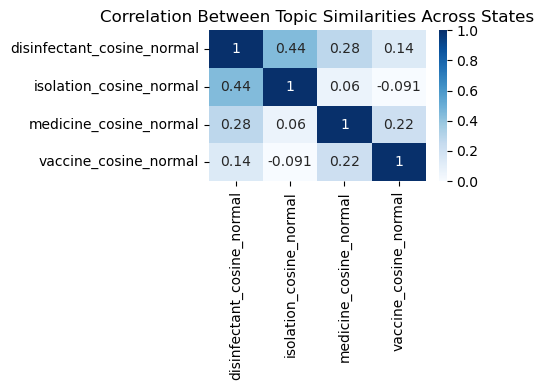


PCA explained variance ratio per component:
 PC1: 0.3966
 PC2: 0.2953
 PC3: 0.1869
 PC4: 0.1213
Cumulative variance explained:
 up to PC1: 0.3966
 up to PC2: 0.6918
 up to PC3: 0.8787
 up to PC4: 1.0000


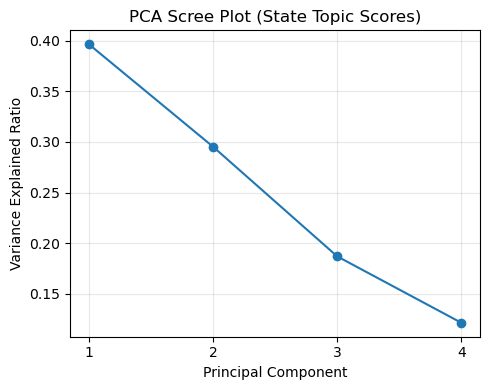


DIAGNOSTIC ANALYSIS END


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



print("DIAGNOSTIC ANALYSIS START")

topic_cols = [
    "disinfectant_cosine_normal",
    "isolation_cosine_normal",
    "medicine_cosine_normal",
    "vaccine_cosine_normal"
]

X = state_topic_df[topic_cols].values

# 1. Show basic spread per feature
desc = state_topic_df[topic_cols].describe().T
desc["range"] = desc["max"] - desc["min"]
print("\nFeature spread across states:")
print(desc[["min", "max", "mean", "std", "range"]].round(4))

# 2. Correlation heatmap between topics
corr_mat = state_topic_df[topic_cols].corr()
plt.figure(figsize=(5,4))
sns.heatmap(corr_mat, annot=True, vmin=0, vmax=1, cmap="Blues")
plt.title("Correlation Between Topic Similarities Across States")
plt.tight_layout()
plt.show()

# 3. PCA variance 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=4, random_state=42)
pca.fit(X_scaled)

explained = pca.explained_variance_ratio_
cumulative = np.cumsum(explained)

print("\nPCA explained variance ratio per component:")
for i, val in enumerate(explained, start=1):
    print(f" PC{i}: {val:.4f}")

print("Cumulative variance explained:")
for i, val in enumerate(cumulative, start=1):
    print(f" up to PC{i}: {val:.4f}")

# Plot scree curve 
plt.figure(figsize=(5,4))
plt.plot(range(1, len(explained)+1), explained, marker="o")
plt.xticks(range(1, len(explained)+1))
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained Ratio")
plt.title("PCA Scree Plot (State Topic Scores)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\nDIAGNOSTIC ANALYSIS END")


---

## Part VII: Determining Optimal Clusters
### Q8: Calinski–Harabasz Score Evaluation

In this step, I calculate the **Calinski–Harabasz (CH) score** for both **K-Means** and **Spectral Clustering** algorithms across different cluster counts (k = 2 to 20).  


Calculating Calinski–Harabasz scores

Calculating Calinski–Harabasz scores for k = 2–20...


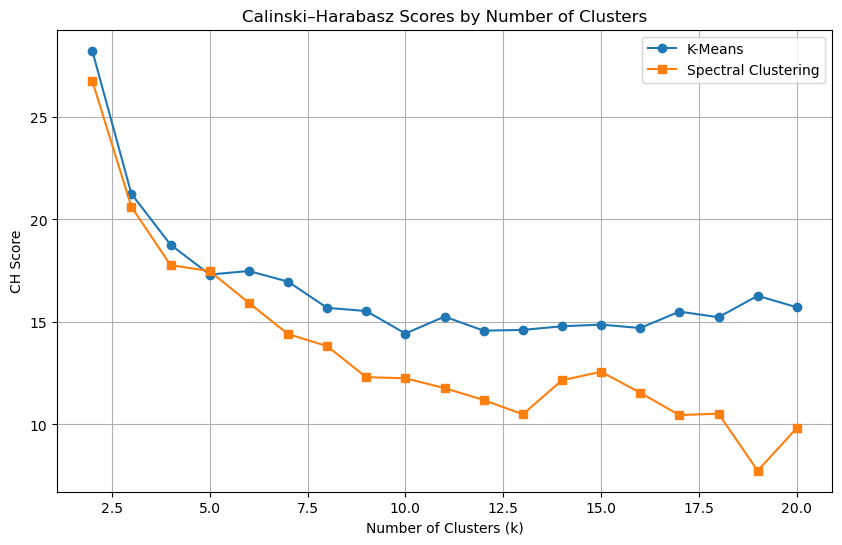


Best K-Means CH score: 28.23 at k = 2
Best Spectral CH score: 26.77 at k = 2

Elapsed time for Q8: 0.94 seconds


In [20]:
start_time = time.time()

from sklearn.metrics import calinski_harabasz_score
import matplotlib.pyplot as plt

# reload dataset
state_topic_df = pd.read_csv("state_topic_score_data.csv")
X = state_topic_df[[
    "disinfectant_cosine_normal",
    "isolation_cosine_normal",
    "medicine_cosine_normal",
    "vaccine_cosine_normal"
]]

# define range of cluster numbers
k_values = range(2, 21)
kmeans_scores = []
spectral_scores = []

print("Calculating Calinski–Harabasz scores for k = 2–20...")

for k in k_values:
    # K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X)
    kmeans_score = calinski_harabasz_score(X, kmeans_labels)
    kmeans_scores.append(kmeans_score)
    
    # Spectral Clustering
    spectral = SpectralClustering(n_clusters=k, affinity='nearest_neighbors',
                                  random_state=42, assign_labels='kmeans')
    spectral_labels = spectral.fit_predict(X)
    spectral_score = calinski_harabasz_score(X, spectral_labels)
    spectral_scores.append(spectral_score)

# visualize
plt.figure(figsize=(10, 6))
plt.plot(k_values, kmeans_scores, marker='o', label='K-Means')
plt.plot(k_values, spectral_scores, marker='s', label='Spectral Clustering')
plt.title("Calinski–Harabasz Scores by Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("CH Score")
plt.legend()
plt.grid(True)
plt.show()

# report best scores
best_k_kmeans = k_values[np.argmax(kmeans_scores)]
best_k_spectral = k_values[np.argmax(spectral_scores)]

print(f"\nBest K-Means CH score: {max(kmeans_scores):.2f} at k = {best_k_kmeans}")
print(f"Best Spectral CH score: {max(spectral_scores):.2f} at k = {best_k_spectral}")

elapsed_time_q8 = time.time() - start_time
print(f"\nElapsed time for Q8: {elapsed_time_q8:.2f} seconds")


---

## Part VIII: Descriptive Visualization
### Q9: Parallel Coordinates Plot for States

In this step, I create a **parallel coordinates plot** to visualize how states differ across the four topic similarity scores: disinfectant, isolation, medicine, and vaccine.  


#### Parallel corrdinates plots

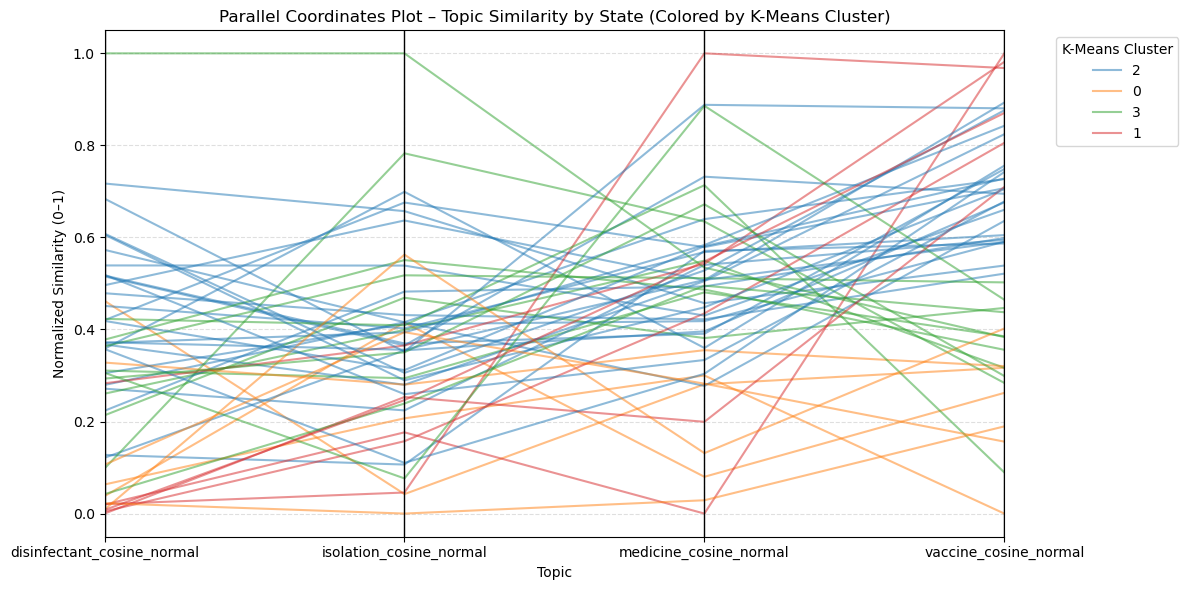

Elapsed time for Q9: 0.34 seconds


In [21]:
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
from sklearn.cluster import KMeans, SpectralClustering
import pandas as pd
import numpy as np
import time

start_time = time.time()

# Reload the base dataset
state_topic_df = pd.read_csv("state_topic_score_data.csv")

# Recreate K-Means and Spectral Clustering
X = state_topic_df[
    ["disinfectant_cosine_normal", "isolation_cosine_normal",
     "medicine_cosine_normal", "vaccine_cosine_normal"]
]

# K-Means 
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
state_topic_df["kmeans_cluster"] = kmeans.fit_predict(X)

# Spectral Clustering 
spectral = SpectralClustering(
    n_clusters=4, affinity="nearest_neighbors", random_state=42
)
state_topic_df["spectral_cluster"] = spectral.fit_predict(X)

# Add Category column for coloring
state_topic_df["Category"] = state_topic_df["kmeans_cluster"].astype(str)

# Normalize again for consistent visualization
cols = [
    "disinfectant_cosine_normal",
    "isolation_cosine_normal",
    "medicine_cosine_normal",
    "vaccine_cosine_normal"
]
state_topic_df[cols] = state_topic_df[cols].apply(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Plot colored by K-Means cluster
plt.figure(figsize=(12, 6))
parallel_coordinates(
    state_topic_df,
    class_column="Category",
    cols=cols,
    color=plt.cm.tab10.colors[:state_topic_df["Category"].nunique()],
    alpha=0.5
)
plt.title("Parallel Coordinates Plot – Topic Similarity by State (Colored by K-Means Cluster)")
plt.xlabel("Topic")
plt.ylabel("Normalized Similarity (0–1)")
plt.legend(title="K-Means Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

elapsed_time_q9 = time.time() - start_time
print(f"Elapsed time for Q9: {elapsed_time_q9:.2f} seconds")



These differences highlight that states vary in their dominant COVID-19 discussion themes, and clustering successfully captures these patterns even when numerical differences are subtle.

# ## Q10 – Regional Topic Trends Visualization

#### Visuslatztion

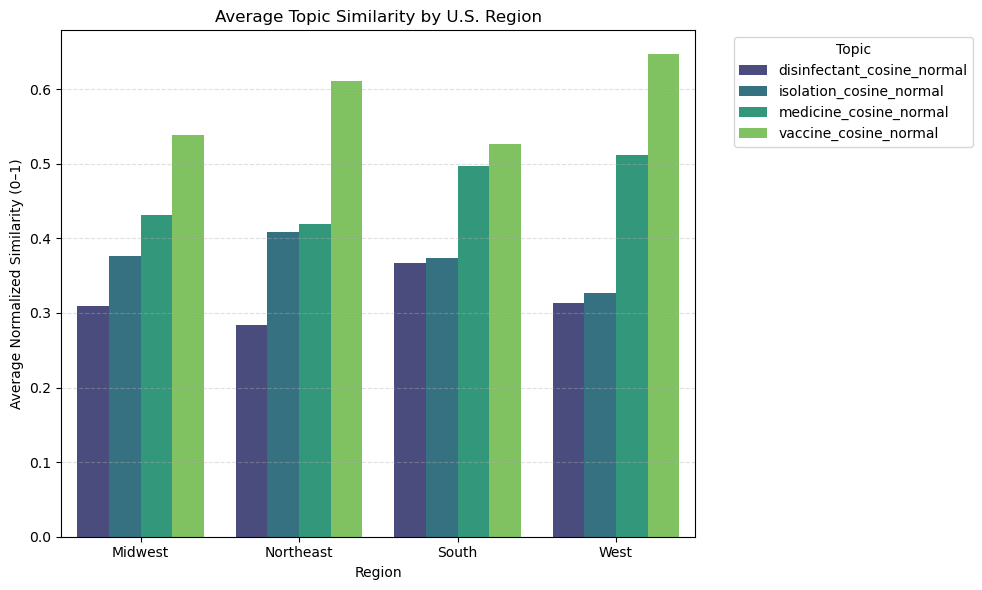

Elapsed time for Q10: 0.38 seconds

Regional averages:
       region  disinfectant_cosine_normal  isolation_cosine_normal  \
0    Midwest                      0.3094                   0.3763   
1  Northeast                      0.2840                   0.4085   
2      South                      0.3667                   0.3739   
3       West                      0.3127                   0.3265   

   medicine_cosine_normal  vaccine_cosine_normal  
0                  0.4317                 0.5384  
1                  0.4199                 0.6103  
2                  0.4971                 0.5271  
3                  0.5116                 0.6465  


In [22]:
# imports
import matplotlib.pyplot as plt
import seaborn as sns
import time

start_time = time.time()

# Merge regional info back into the state_topic_df using the unique state field
region_map = tweets_us_df[["state", "region"]].drop_duplicates()
state_topic_df = state_topic_df.merge(region_map, on="state", how="left")

# Group by region to compute mean similarity per topic
region_topic_df = state_topic_df.groupby("region")[[
    "disinfectant_cosine_normal",
    "isolation_cosine_normal",
    "medicine_cosine_normal",
    "vaccine_cosine_normal"
]].mean().reset_index()

# Melt for plotting
region_melted = region_topic_df.melt(
    id_vars="region",
    var_name="Topic",
    value_name="Average Similarity"
)

# Create grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(
    data=region_melted,
    x="region",
    y="Average Similarity",
    hue="Topic",
    palette="viridis"
)
plt.title("Average Topic Similarity by U.S. Region")
plt.xlabel("Region")
plt.ylabel("Average Normalized Similarity (0–1)")
plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

elapsed_time_q10 = time.time() - start_time
print(f"Elapsed time for Q10: {elapsed_time_q10:.2f} seconds")

# Preview numerical results
print("\nRegional averages:\n", region_topic_df.round(4))

## Q11 – PCA Visualization of Clustering Results



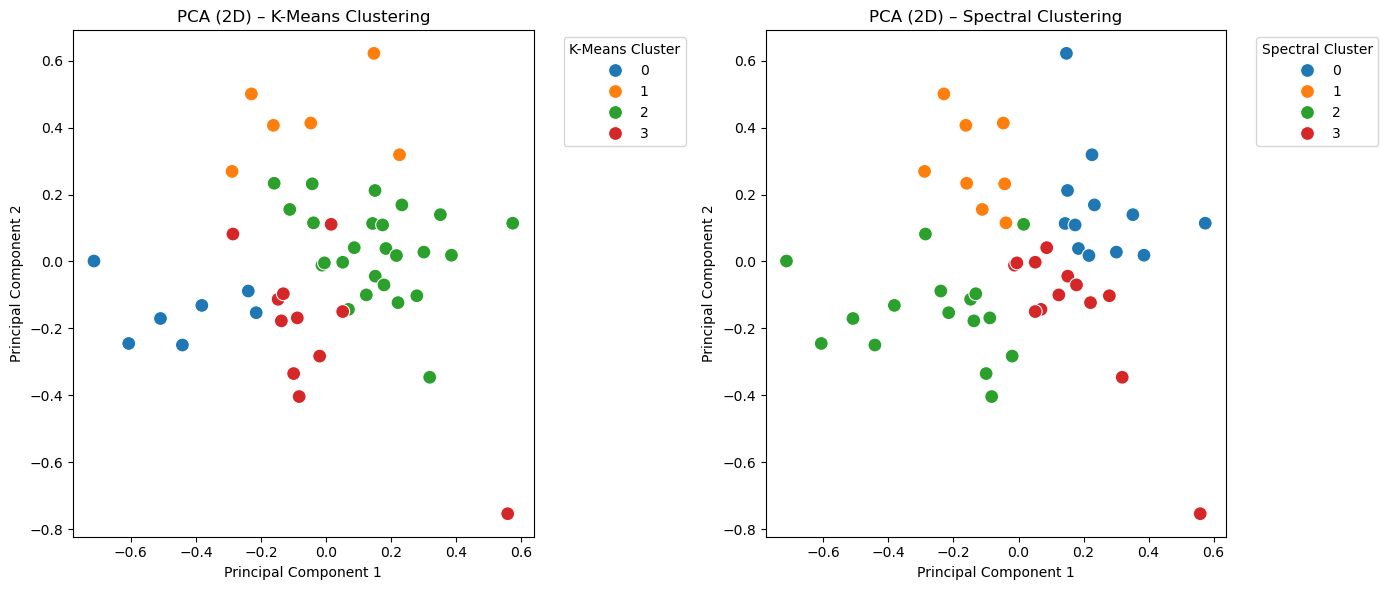

[0.39267473 0.31637503]
Elapsed time for Q11: 1.16 seconds


In [23]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import time

start_time = time.time()

# Select topic related features for PCA
topic_features = [
    "disinfectant_cosine_normal",
    "isolation_cosine_normal",
    "medicine_cosine_normal",
    "vaccine_cosine_normal"
]

# Run PCA with 2 components
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(state_topic_df[topic_features])
state_topic_df["PCA1"] = pca_result[:, 0]
state_topic_df["PCA2"] = pca_result[:, 1]

# Plot sidebyside scatterplots for K-Means and Spectral Clustering
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# K-Means
sns.scatterplot(
    data=state_topic_df,
    x="PCA1", y="PCA2",
    hue="kmeans_cluster",
    palette="tab10", s=100, ax=axes[0]
)
axes[0].set_title("PCA (2D) – K-Means Clustering")
axes[0].set_xlabel("Principal Component 1")
axes[0].set_ylabel("Principal Component 2")
axes[0].legend(title="K-Means Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")

# Spectral Clustering
sns.scatterplot(
    data=state_topic_df,
    x="PCA1", y="PCA2",
    hue="spectral_cluster",
    palette="tab10", s=100, ax=axes[1]
)
axes[1].set_title("PCA (2D) – Spectral Clustering")
axes[1].set_xlabel("Principal Component 1")
axes[1].set_ylabel("Principal Component 2")
axes[1].legend(title="Spectral Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

elapsed_time_q11 = time.time() - start_time
print(pca.explained_variance_ratio_)
print(f"Elapsed time for Q11: {elapsed_time_q11:.2f} seconds")
